# Dropout 

Dropout is a regularization technique used in deep neural networks to prevent overfitting, which occurs when a model learns to perform exceptionally well on the training data but fails to generalize to new, unseen data. Introduced by Geoffrey Hinton and his colleagues in 2012, dropout helps to improve the generalization ability of neural networks by introducing randomness during training.

## **How Dropout Works**
- **Randomly Dropping Neurons**: During the training process, dropout randomly "drops out" a certain percentage of neurons (or units) in a layer during each forward pass. This means that during training, the output of some neurons is set to zero at random. The neurons to drop are selected independently with a probability \( p \), known as the dropout rate. For instance, if \( p = 0.5 \), approximately half of the neurons in the layer are dropped during each forward pass.
  
- **Effect on Network Structure**: Because different subsets of neurons are dropped in each training iteration, dropout effectively trains multiple different sub-networks within the full network. This creates an ensemble-like effect, where the final model is a combination of many different models, each trained on different subsets of the neurons.

- **Scaling During Inference**: During inference (when the model is used for prediction), no neurons are dropped. Instead, the activations of the neurons are scaled down by the dropout rate \( p \). This scaling ensures that the expected output during training and inference remains consistent, compensating for the reduced number of active neurons during training.

## **Advantages of Dropout**
- **Reduces Overfitting**: By preventing any single neuron from becoming too reliant on another, dropout forces the network to develop more robust features that are not tied to specific neuron activations. This reduces the likelihood of overfitting to the training data.
  
- **Improves Generalization**: The randomness introduced by dropout helps the network to generalize better to unseen data by making it less sensitive to noise and more capable of handling variations in the input.

- **Efficient and Easy to Implement**: Dropout is computationally efficient and easy to implement in most deep learning frameworks, making it a popular choice for regularization in neural networks.

## **Common Usage**
- **Dropout Rate**: The dropout rate \( p \) is typically set between 0.2 and 0.5 for most layers. For input layers, a lower dropout rate is often used, while higher dropout rates are more common in deeper layers.
  
- **Layers**: Dropout is usually applied to fully connected layers in the network. It can also be used in convolutional layers, although in such cases, the dropout is often applied spatially, where entire feature maps are dropped rather than individual neurons.

## **Potential Drawbacks**
- **Training Time**: Dropout can increase the training time because it effectively trains multiple different models simultaneously. However, the benefits in terms of generalization often outweigh this drawback.
  
- **Not Always Necessary**: In some cases, particularly with very large datasets or when other regularization techniques (such as weight decay) are already being used, dropout might not provide significant additional benefits.

# Early Stopping

Early Stopping is a practical and widely-used technique in training deep neural networks. It is a regularization technique used in training deep neural networks to prevent overfitting. Overfitting occurs when a model learns not only the underlying pattern in the training data but also the noise, leading to poor generalization on unseen data. Early Stopping addresses this by halting the training process once the model's performance on a validation set starts to degrade. It helps to ensure that the model remains robust and generalizes well to new, unseen data by halting training at the optimal point before overfitting occurs.

### How It Works

1. **Training and Validation Sets**: During training, the dataset is typically split into three parts:
   - **Training Set**: Used to update the model's weights.
   - **Validation Set**: Used to monitor the model's performance during training.
   - **Test Set**: Used to evaluate the model's performance after training is complete (not involved in Early Stopping).

2. **Monitoring Validation Loss**: 
   - As the model trains, it typically improves its performance on the training set, leading to a decrease in training loss.
   - The validation loss is calculated after each epoch (a complete pass through the training data) to gauge how well the model generalizes to unseen data.
   - Initially, as the model learns, both training and validation losses decrease. However, after a certain point, the validation loss may start to increase, indicating that the model is beginning to overfit.

3. **Stopping Criterion**:
   - Early Stopping involves monitoring the validation loss and stopping the training process when this loss stops decreasing and starts to increase.
   - The point at which training is stopped is often determined by a **patience** parameter, which defines how many epochs the training process should wait for an improvement in validation loss before stopping.
   - For example, if the patience is set to 5, the training will stop if there is no improvement in validation loss for 5 consecutive epochs.

4. **Restoring Best Weights**:
   - After stopping, the model's weights are typically restored to those from the epoch where the validation loss was lowest, ensuring that the best-performing model is used.

### Advantages

- **Prevents Overfitting**: By stopping training before the model begins to overfit, Early Stopping helps in achieving better generalization to new data.
- **Saves Computational Resources**: Early Stopping can reduce the time and computational cost of training, as the training process may end well before the maximum number of epochs is reached.
- **No Hyperparameter Tuning Required**: It doesn't require extensive tuning of hyperparameters like regularization strength, making it a simple yet effective method.

### Disadvantages

- **Validation Set Dependence**: The effectiveness of Early Stopping relies heavily on the validation set. If the validation set is not representative of the test set, Early Stopping might either stop too early or too late.
- **Potential Underfitting**: If not carefully monitored, Early Stopping might stop training too soon, leading to an underfit model that hasn't fully learned the underlying patterns.

# Demo: MNIST 

Neste notebook, um rede MLP é treinada com o conjunto [MNIST](https://). O propósito é ilustrar duas técnicas usadas durante o treinamento de redes neurais:
- *Early Stopping*
- *Dropout*.

![link text](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

CREDITS: The example code in this section is adapted from https://github.com/Bjarten/early-stopping-pytorch/blob/master/MNIST_Early_Stopping_example.ipynb

In [1]:
# import libraries
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [3]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

def create_datasets(batch_size):

    # percentage of training set to use as validation
    valid_size = 0.2

    # convert data to torch.FloatTensor
    transform = transforms.ToTensor()

    # choose the training and test datasets
    train_data = datasets.MNIST(root='data', 
                                train=True,
                                download=True, 
                                transform=transform)

    test_data = datasets.MNIST(root='data',
                               train=False,
                               download=True,
                               transform=transform)

    # obtain training indices that will be used for validation
    num_train = len(train_data)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]
    
    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    # load training data in batches
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               sampler=train_sampler,
                                               num_workers=0)
    
    # load validation data in batches
    valid_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               sampler=valid_sampler,
                                               num_workers=0)
    
    # load test data in batches
    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_size,
                                              num_workers=0)
    
    return train_loader, test_loader, valid_loader

Now we build the NN, once again implemented as a subclass of `torch.nn.Module`.

We use a Multilayer Perceptron with 2 hidden layers.

- Input layer: 784 units (28 x 28)
- First hidden layer: 128 units (neurons)
- Second hidden layer: 128 units
- Output layer: 10 units

Both hidden layers use dropout to control overfitting, with dropout rate = 0.5. They also are configured with ReLU activation function.

The output layer

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        # add output layer
        x = self.fc3(x)
        return x

# initialize the NN
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


Next, we set the loss function and the optimizer. For the loss function, we use cross entropy, since we are building a predictive model for classification. For the optimizer, [Adam](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) is used.

In [5]:
# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.Adam(model.parameters())

The function bellow presents the code for training the NN.

Notice that **Early Stopping** regularization technique is used in the function bellow. Early stopping needs access to the validation loss to check if it has decreased or not. If it is the case the the loss has decreased, it will make a checkpoint of the current model. A checkpoint corresponds to saving the current model to disk.

Also, notice that the function bellow used minibatch training. This way, for training epoch, several batchs of examples are given to the NN, and the parameters are updated for each batch. The size of each minibatch is passed as an argument to the function.

In [6]:
def train_model(model, patience, n_epochs):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for batch, (data, target) in enumerate(train_loader, 1):
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for data, target in valid_loader:
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # record validation loss
            valid_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    return  model, avg_train_losses, avg_valid_losses

The next code cell sets three other hyperparameters: the amount of training epochs, the bacth size, and the patience (for Early Stopping). After that the loaders for train and validation sets are created, and the traininn process is executed.

In [7]:
n_epochs = 100
batch_size = 128

train_loader, test_loader, valid_loader = create_datasets(batch_size)

# early stopping patience; how long to wait after last time validation loss improved.
patience = 20

model, train_loss, valid_loss = train_model(model, patience, n_epochs)

[  1/100] train_loss: 0.67649 valid_loss: 0.26411
Validation loss decreased (inf --> 0.264110).  Saving model ...
[  2/100] train_loss: 0.32469 valid_loss: 0.19642
Validation loss decreased (0.264110 --> 0.196416).  Saving model ...
[  3/100] train_loss: 0.26611 valid_loss: 0.16753
Validation loss decreased (0.196416 --> 0.167526).  Saving model ...
[  4/100] train_loss: 0.23020 valid_loss: 0.14843
Validation loss decreased (0.167526 --> 0.148429).  Saving model ...
[  5/100] train_loss: 0.21293 valid_loss: 0.13798
Validation loss decreased (0.148429 --> 0.137981).  Saving model ...
[  6/100] train_loss: 0.19554 valid_loss: 0.12738
Validation loss decreased (0.137981 --> 0.127378).  Saving model ...
[  7/100] train_loss: 0.18314 valid_loss: 0.12195
Validation loss decreased (0.127378 --> 0.121953).  Saving model ...
[  8/100] train_loss: 0.17253 valid_loss: 0.12245
EarlyStopping counter: 1 out of 20
[  9/100] train_loss: 0.16571 valid_loss: 0.11384
Validation loss decreased (0.121953 -

/tmp/ipykernel_22281/3252275328.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoint.pt'))


Since the train and validation losses were tracked during training, we can plot their values. This is done in the code cell bellow.

The generated plot presents two curves, one for the training losses, and another for the validation losses. A dotted red line is also presented. This line corresponds to the moment in which the best model (as measured on the validation set) is generated. Also notice that the training process continues after that moment for a few more epochs, duw to the value of the *patience* hyperparameter.

One thing that may seem strage at first is that the error on the train dataset if greated than the error on the validation set. However, this is an expected behaviour, since dropout is being used. For more details about this, see the discussion [here](stats.stackexchange.com/questions/187335/validation-error-less-than-training-error).

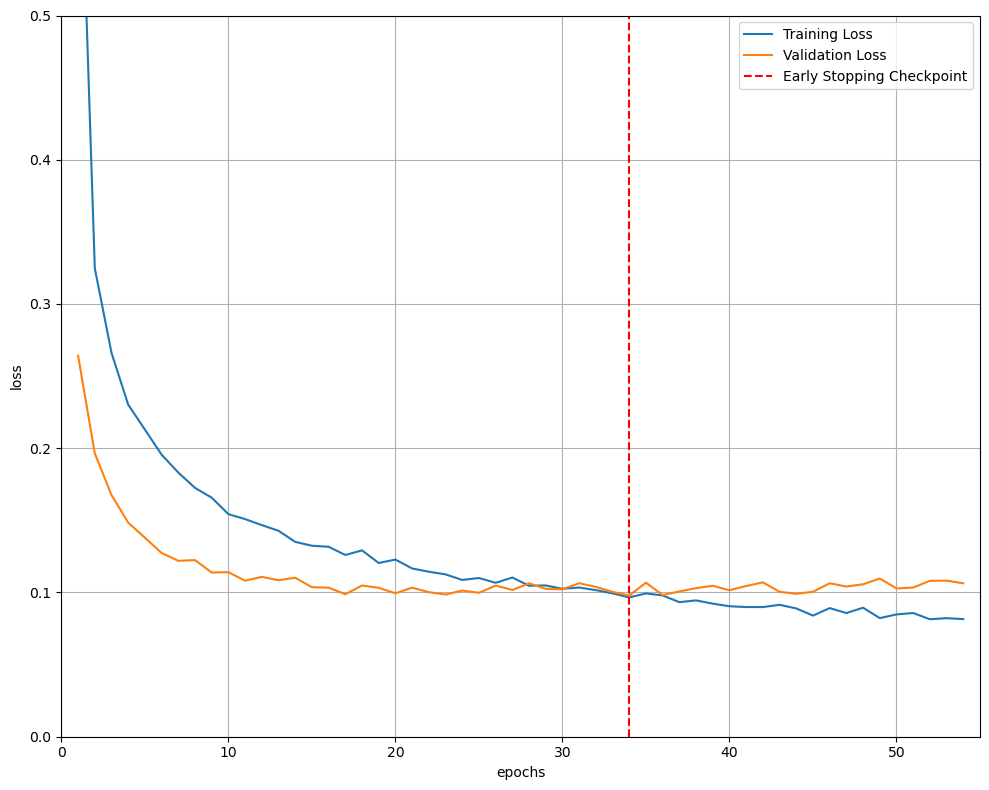

In [8]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 0.5) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

Now that the training process is finished, we can evaluate the generated model on the test set to get an estimate of its generalization perfomance.

In [9]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for data, target in test_loader:
    if len(target.data) != batch_size:
        break
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.089700

Test Accuracy of     0: 98% (967/979)
Test Accuracy of     1: 99% (1123/1133)
Test Accuracy of     2: 97% (1008/1030)
Test Accuracy of     3: 97% (979/1008)
Test Accuracy of     4: 97% (957/980)
Test Accuracy of     5: 97% (870/890)
Test Accuracy of     6: 97% (933/956)
Test Accuracy of     7: 96% (995/1027)
Test Accuracy of     8: 96% (938/973)
Test Accuracy of     9: 95% (965/1008)

Test Accuracy (Overall): 97% (9735/9984)


As a sanity check, we can also print some of the example images in the test dataset, along with the predicted label for each one of them.

In [10]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

AttributeError: '_SingleProcessDataLoaderIter' object has no attribute 'next'